In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 102.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=ce219242215ae931f7f8e6f06791239f38193ae33e6eebbfea8bf0b50e1b425c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
%load_ext autoreload
%autoreload 2
import collections
import re
import copy
import datetime
import random
import traceback
import numpy as np
import scipy.sparse
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE


import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
file_path = '/content/Text_Recommendations.txt'
#file_path = '/content/Text_Recommendations.rar'
with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
text = text.replace('\n', '')
with open(file_path, 'w', encoding='utf-8') as file:
    file.write(text)
print("Переходы на новую строку удалены")

Переходы на новую строку удалены


In [ ]:
# Загрузка модуля для нормализации слов
morph = MorphAnalyzer()

# Текст для обработки
file_path = '/content/Text_Recommendations.txt'
#file_path = '/content/Text_Recommendations.rar'
with open(file_path, 'r') as file:
    text = file.read()

In [ ]:
# Разделение текста на предложения
sentences = sent_tokenize(text, language='russian')
# Список стоп-слов для удаления
stop_words = set(stopwords.words('russian'))

In [ ]:
# Функция для нормализации слова
def normalize_word(word):
    parsed_word = morph.parse(word)[0]
    return parsed_word.normal_form

# Функция для обработки предложения
def process_sentence(sentence):
    words = nltk.word_tokenize(sentence, language='russian')
    normalized_words = [normalize_word(word) for word in words if word.isalpha() and word not in stop_words]
    return normalized_words

In [ ]:
# Создание фреймов данных
dataFull = {'Предложения': [], 'Нормализованный текст': []}
dataPart = {'Предложения': []}

# Обработка каждого предложения
for sentence in sentences:
    normalized_words = process_sentence(sentence)
    dataFull['Предложения'].append(sentence)
    dataPart['Предложения'].append(sentence)
    dataFull['Нормализованный текст'].append(normalized_words)

In [ ]:
dfFull = pd.DataFrame(dataFull)
dfPart = pd.DataFrame(dataPart)


In [ ]:
dfFull.head()

,Предложения,Нормализованный текст
0,Хроническая обструктивная болезнь легких (ХОБЛ...,"[хронический, обструктивный, болезнь, лёгкий, ..."
1,Обострения и коморбидные состояния являются не...,"[обострение, коморбидный, состояние, являться,..."
2,Курение остается основной причиной ХОБЛ.,"[курение, оставаться, основной, причина, хобл]"
3,"По некоторым оценкам, в индустриальных странах...","[по, некоторый, оценка, индустриальный, страна..."
4,В развивающихся странах существенное повреждаю...,"[в, развивающийся, страна, существенный, повре..."


In [ ]:
dfPart.head()

,Предложения
0,Хроническая обструктивная болезнь легких (ХОБЛ...
1,Обострения и коморбидные состояния являются не...
2,Курение остается основной причиной ХОБЛ.
3,"По некоторым оценкам, в индустриальных странах..."
4,В развивающихся странах существенное повреждаю...


In [ ]:
dfFull.to_csv('fileFull.csv', index=False)
dfPart.to_csv('filePart.csv', index=False)

In [ ]:
TOKEN_RE = re.compile(r'[\w\d]+')

# Функция выполняет токенизацию текста txt  с использованием регулярного выражения, возвращая список токенов, удовлетворяющих заданному минимальному размеру min_token_size
def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

# Функция разбивает текст txt на отдельные символы, возвращая список символов
def character_tokenize(txt):
    return list(txt)

# Функция осуществляет токенизацию корпуса текстов texts с помощью указанного токенизатора (по умолчанию tokenize_text_simple_regex), возвращая список списков токенов для каждого текста
def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

# Функция  добавляет фиктивный токен с индексом 0 в словарь word2id, присваивая ему указанный токен (по умолчанию <PAD>), и возвращает обновленный словарь
def add_fake_token(word2id, token='<PAD>'):
    word2id_new = {token: i + 1 for token, i in word2id.items()}
    word2id_new[token] = 0
    return word2id_new

# Функция преобразует список списков токенов tokenized_texts в список списков их соответствующих идентификаторов на основе словаря word2id, возвращая результат
def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]

# Функция  строит словарь word2id на основе токенизированных текстов tokenized_texts
def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])

    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


PAD_TOKEN = '__PAD__'
NUMERIC_TOKEN = '__NUMBER__'
NUMERIC_RE = re.compile(r'^([0-9.,e+\-]+|[mcxvi]+)$', re.I)

# Функция заменяет числовые токены в списках токенов tokenized_texts на специальный токен NUMERIC_TOKEN, возвращая обновленные списки токенов
def replace_number_nokens(tokenized_texts):
    return [[token if not NUMERIC_RE.match(token) else NUMERIC_TOKEN for token in text]
            for text in tokenized_texts]

In [ ]:
class Embeddings:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def most_similar(self, word, topk=10):
        return self.most_similar_by_vector(self.get_vector(word), topk=topk)

    def analogy(self, a1, b1, a2, topk=10):
        a1_v = self.get_vector(a1)
        b1_v = self.get_vector(b1)
        a2_v = self.get_vector(a2)
        query = b1_v - a1_v + a2_v
        return self.most_similar_by_vector(query, topk=topk)

    def most_similar_by_vector(self, query_vector, topk=10):
        similarities = (self.embeddings * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
        result = [(self.id2word[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors

In [ ]:
def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target

# Функция создает маску на основе длин последовательностей lengths и максимальной длины max_length, где 1 указывает на наличие элемента в последовательности, а 0 на паддинг
def make_mask_from_lengths(lengths, max_length):
    result = torch.zeros(len(lengths), max_length, dtype=torch.bool)
    for sample_i, cur_len in enumerate(lengths):
        result[sample_i, :cur_len] = 1
    return result

In [ ]:
# Функция устанавливает случайное зерно для генераторов случайных чисел в Python и PyTorch с целью воспроизводимости результатов
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

# Функция копирует данные data на указанное устройство device, поддерживая как тензоры PyTorch, так и списки/кортежи с вложенными тензорами
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))

# Функция выводит статистику градиентов модели model, включая среднее значение, стандартное отклонение и норму градиентов
def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')

# Функция реализует цикл обучения модели с оценкой качества на отложенной выборке после каждой эпохи
def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

# Функция выполняет прогнозирование с использованием обученной модели на указанном наборе данных
def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

In [ ]:
# Функция строит визуализацию векторов. Она принимает векторы (vectors) и метки (labels) в качестве параметров? использует алгоритмы t-SNE или SVD для снижения размерности векторов и отображает результат на плоскости
def plot_vectors(vectors, labels, how='tsne', ax=None):
    if how == 'tsne':
        projections = TSNE().fit_transform(vectors)
    elif how == 'svd':
        projections = TruncatedSVD().fit_transform(vectors)

    x = projections[:, 0]
    y = projections[:, 1]

    ax.scatter(x, y)
    for cur_x, cur_y, cur_label in zip(x, y, labels):
        ax.annotate(cur_label, (cur_x, cur_y))

In [ ]:
init_random_seed()
full_dataset = list(pd.read_csv('/content/filePart.csv')['Предложения'].dropna())
#full_dataset = full_dataset * 10
random.shuffle(full_dataset)

TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.8)
train_source = full_dataset[:TRAIN_VAL_SPLIT]
test_source = full_dataset[TRAIN_VAL_SPLIT:]
print("Обучающая выборка", len(train_source))
print("Тестовая выборка", len(test_source))
print()
print('\n'.join(train_source[:10]))

Обучающая выборка 944
Тестовая выборка 237

Однако данный эффект не наблюдался ни при использова-нии ингаляционного будесонида в исследовании EURO-SCOP,  ни  при  использовании  ингаляционного флутиказона пропионата в исследовании TORCH.
Бисопролол влиял на параметры внешнего дыхания лучше карведилола.
При наличии соответствующих показаний во время тренировки следует использовать различные виды респираторной поддержки.
Хроническая обструктивная болезнь легких (ХОБЛ) – это заболевание, при котором нарушается прохождение воздуха по бронхам и попадание кислорода и легкого в кровь.
При этом при гриппе и ОРВИ одышка и затрудненное дыхание отмечаются значительно реже, чем при COVID-19.При вирусных гастроэнтеритах ведущим будет поражение желудочно-кишечного тракта (ЖКТ), симптомы поражения дыхательных путей, как правило, выражены минимально.В целом при проведении дифференциальной диагностики необходимо учитывать данные эпидемиологического анамнеза, клинические симптомы и их динамику.
В недавн

In [ ]:
# токенизируем
train_tokenized = tokenize_corpus(train_source)
test_tokenized = tokenize_corpus(test_source)
print('\n'.join(' '.join(sent) for sent in train_tokenized[:10]))

однако данный эффект наблюдался использова ингаляционного будесонида исследовании euro scop использовании ингаляционного флутиказона пропионата исследовании torch
бисопролол влиял параметры внешнего дыхания лучше карведилола
наличии соответствующих показаний время тренировки следует использовать различные виды респираторной поддержки
хроническая обструктивная болезнь легких хобл заболевание котором нарушается прохождение воздуха бронхам попадание кислорода легкого кровь
этом гриппе орви одышка затрудненное дыхание отмечаются значительно реже covid вирусных гастроэнтеритах ведущим будет поражение желудочно кишечного тракта симптомы поражения дыхательных путей правило выражены минимально целом проведении дифференциальной диагностики необходимо учитывать данные эпидемиологического анамнеза клинические симптомы динамику
недавно проведенном исследовании ежедневном приеме азитромицина отмечалась эффективность отношении влияния обострения конечную точку исследования однако прием препарата мож

In [ ]:
# строим словарь
vocabulary, word_doc_freq = build_vocabulary(train_tokenized, max_doc_freq=0.9, min_count=5, pad_word='<PAD>')
print("Размер словаря", len(vocabulary))
print(list(vocabulary.items())[:10])

Размер словаря 1201
[('<PAD>', 0), ('хобл', 1), ('пациентов', 2), ('легких', 3), ('может', 4), ('является', 5), ('рекомендуется', 6), ('заболевания', 7), ('более', 8), ('также', 9)]


In [ ]:
# отображаем в номера токенов
train_token_ids = texts_to_token_ids(train_tokenized, vocabulary)
test_token_ids = texts_to_token_ids(test_tokenized, vocabulary)

print('\n'.join(' '.join(str(t) for t in sent)
                for sent in train_token_ids[:10]))

21 566 286 947 189 339 947 189
948 110 760
40 949 16 340 15 141 950 170 190
657 761 250 3 1 133 486 111 112 118
155 659 113 489 222 567 59 951 762 96 312 28 85 341 658 409 223 71 53 487 95 488 313 96
763 189 251 660 253 25 60 21 568 156 4 14 952 490 252
15 157 45 103 20 97 45 953 205 76 569 171 81 54 44 410 570 254
2 86 41 366 59 956 958 342 959 46 55 37 957 491 661 411 955 662 314 29 224 954 16 23
21 412 1 571 492 343 134
663 13 20 173 147 23 13 20 173 147 119 6 1 414 493 764 960 315 20 6 157 413 172 961 962 22


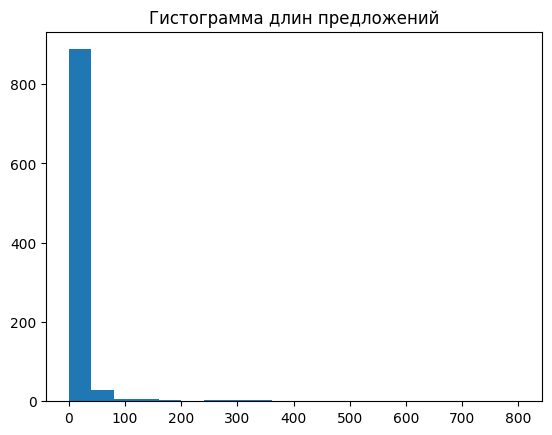

In [ ]:
plt.hist([len(s) for s in train_token_ids], bins=20);
plt.title('Гистограмма длин предложений');

In [ ]:
MAX_SENTENCE_LEN = 20
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
test_dataset = PaddedSequenceDataset(test_token_ids,
                                     np.zeros(len(test_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)
print(train_dataset[0])

(tensor([ 21, 566, 286, 947, 189, 339, 947, 189,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]), tensor(0))


In [ ]:
# Функция создает диагональную матрицу-маску
def make_diag_mask(size, radius):
    """Квадратная матрица размера Size x Size с двумя полосами ширины radius вдоль главной диагонали"""
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask

make_diag_mask(10, 3)

tensor([[0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 1., 1., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 0., 1., 1., 1., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.]])

In [ ]:

class SkipGramNegativeSamplingTrainer(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=5, negative_samples_n=5):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)

    def forward(self, sentences):
        """sentences - Batch x MaxSentLength - идентификаторы токенов"""
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с настоящими соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности встретить эти пары слов вместе
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN

        # уменьшить оценку вероятность встретить эти пары слов вместе
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


def no_loss(pred, target):
    """Фиктивная функция потерь - когда модель сама считает функцию потерь"""
    return pred

# Обучение модели

In [ ]:
#Обучение
trainer = SkipGramNegativeSamplingTrainer(len(vocabulary), 100, MAX_SENTENCE_LEN,
                                          radius=5, negative_samples_n=25)

In [ ]:
best_val_loss, best_model = train_eval_loop(trainer,
                                            train_dataset,
                                            test_dataset,
                                            no_loss,
                                            lr=1e-2,
                                            epoch_n=5,
                                            batch_size=8,
                                            device='cpu',
                                            early_stopping_patience=10,
                                            max_batches_per_epoch_train=2000,
                                            max_batches_per_epoch_val=len(test_dataset),
                                            lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

Эпоха 0
Эпоха: 118 итераций, 0.58 сек
Среднее значение функции потерь на обучении 0.9036612354092679
Среднее значение функции потерь на валидации 0.8392139832178752
Новая лучшая модель!

Эпоха 1
Эпоха: 118 итераций, 0.57 сек
Среднее значение функции потерь на обучении 0.8341923265133874
Среднее значение функции потерь на валидации 0.8322254240512847
Новая лучшая модель!

Эпоха 2
Эпоха: 118 итераций, 0.57 сек
Среднее значение функции потерь на обучении 0.802018231759637
Среднее значение функции потерь на валидации 0.8254862070083618
Новая лучшая модель!

Эпоха 3
Эпоха: 118 итераций, 0.59 сек
Среднее значение функции потерь на обучении 0.768842997187275
Среднее значение функции потерь на валидации 0.8383262097835541

Эпоха 4
Эпоха: 118 итераций, 0.71 сек
Среднее значение функции потерь на обучении 0.7380912223104703
Среднее значение функции потерь на валидации 0.8473722000916799
Epoch 00005: reducing learning rate of group 0 to 1.0000e-03.



In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
torch.save(trainer.state_dict(), '/content/sgnsCommon.pth')

In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
trainer.load_state_dict(torch.load('/content/sgnsCommon.pth'))

<All keys matched successfully>

# Тестирование

In [ ]:
embeddings = Embeddings(trainer.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [ ]:
embeddings.most_similar('пневмония')

[('пневмония', 0.9999372),
 ('лихорадка', 0.6006356),
 ('проявления', 0.50886124),
 ('выше', 0.5041805),
 ('пневмонии', 0.49982908),
 ('респираторного', 0.49835402),
 ('особенности', 0.4797008),
 ('часа', 0.46723208),
 ('жалоб', 0.4651318),
 ('эпителия', 0.46473628)]

In [ ]:
test_words = ['хобл', 'пневмония', 'острый', 'пациент', 'эмфизема', 'аспирации', 'инфекций', 'причины']
test_vectors = embeddings.get_vectors(*test_words)
print(test_vectors.shape)

(8, 100)


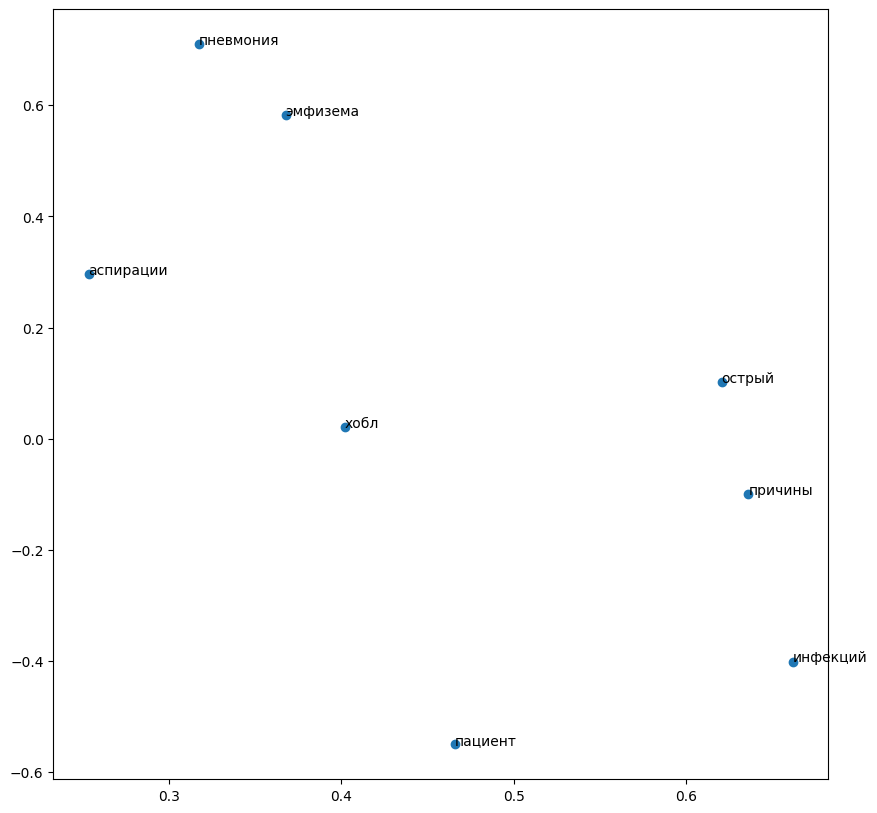

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
plot_vectors(test_vectors, test_words, how='svd', ax=ax)

# Поиск по запросу

In [ ]:
dataFull = pd.read_csv('/content/fileFull.csv')

In [ ]:
# Функция ищет предложения в фрейме данных, содержащие все слова из заданного запроса (query).
def search_sentences(query):
    found_sentences = []
    for index, row in dataFull.iterrows():
        if all(word in row['Нормализованный текст'] for word in query):
            found_sentences.append(row['Предложения'])

    if found_sentences:
        return found_sentences
    else:
        return "К сожалению, информация не найдена"

In [ ]:
# Ввод списка входных данных
input_diagnosis = input("Введите диагноз: ")
#input_words =[str(input_diagnosis)]
input_severity = input("Введите степень тяжести (легкая, средняя, тяжелая, крайне тяжелая) / Пропуск Enter: ")
if input_severity != ("Не выбрано" and ""):
  input_severity = input_severity + " тяжесть"
  #input_words.append("тяжесть")
input_add = input("Дополнительно поиск по ключевым словам: ")
#if (input_add != ''):
  #input_words.append(str(input_add))
input_words =input_diagnosis +" " +input_severity +" "+ input_add
input_words= process_sentence(input_words)
try:
  neighboring_words = embeddings.most_similar(input_diagnosis)
except ValueError:
  neighboring_words = []
if neighboring_words != []:
  post_neighboring_words = []
  for i in neighboring_words:
    if (i[1] > 0.7):
      post_neighboring_words.append(i[0])
  print(post_neighboring_words)
print(input_words)

Введите диагноз: бронхит
Введите степень тяжести (легкая, средняя, тяжелая, крайне тяжелая) / Пропуск Enter: легкая
Дополнительно поиск по ключевым словам: 
['бронхит', 'продукция', 'хронический', 'протяжении', 'собой']
['бронхит', 'лёгкий', 'тяжесть']


In [ ]:
# Поиск совпадений во всем фрейме данных
matches_found = False
advice = []
for index, row in dataFull.iterrows():
    if all(word in row['Нормализованный текст'] for word in input_words):
        advice.append(str(row['Предложения']))
        matches_found = True
if neighboring_words != []:
  for index, row in dataFull.iterrows():
     if all(word in row['Нормализованный текст'] for word in post_neighboring_words):
          advice.append(str(row['Предложения']))
          matches_found = True

if not matches_found:
    print("К сожалению, информация не найдена")

In [ ]:
(list(set(advice)))
for i in advice:
  print(i)

Лечение проводится преимущественно амбулаторно и базируется на определении группы пациента – А, B, С, или D.Лечение стабильной ХОБЛНемедикаментозное лечение ХОБЛ: отказ от курения; физическая активность; реабилитация; вакцинация;Медикаментозное лечение ХОБЛ; Общим подходом к лечению ХОБЛ стабильного течения является ступенчатый принцип усиления терапии в зависимости от тяжести и варианта заболевания.Критерии эффективности лечения стабильной ХОБЛ: Повышение качества жизни больного; Замедление прогрессирования заболевания; Снижение количества обострений; Сохранение функции легких; Сохранение трудоспособности больного.Лечение обострения ХОБЛ в амбулаторных условиях:1) Бронхорасширяющие препараты; Увеличение частоты или дозы принимаемого препарата или добавление бронхолитического препарата другой группы; Для повышения эффективности препаратов рекомендуется их прием с помощью небулайзера или спейсера;2) Глюкокортикоиды; Перорально 30–40мг/сут преднизолона в течение 5 дней с последующей полн